In [32]:
import pandas as pd
import numpy as np
import requests
import json
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import textwrap
from s2_key import *

# Collect and process references

In [2]:
# prefiltered_papers_df = pd.read_csv('annotated-excerpts-with-themes.csv')
# filtered_papers_df = prefiltered_papers_df[prefiltered_papers_df['1 = Relevant / 0 = Irrelevant'] == 1]
# filtered_papers_df = filtered_papers_df[filtered_papers_df['1 = Reference'] != 1]
# filtered_papers = set(filtered_papers_df['Corpus ID'])

In [3]:
# data = {}

# for idx, corpusId in enumerate(filtered_papers):
#     if idx % 20 == 0:
#         print(idx)
    
#     ref_data = requests.get(
#         'https://api.semanticscholar.org/graph/v1/paper/CorpusID:{}/references'.format(corpusId),
#         params={'fields': 'contextsWithIntent,corpusId,venue,title,fieldsOfStudy,s2FieldsOfStudy,citationCount,publicationTypes'},
#         headers = {"Accept": "*/*", "x-api-key": S2_KEY}
#     ).json()

#     if 'data' in ref_data:
#         data[corpusId] = ref_data['data']
    
#         while 'next' in ref_data:
#             ref_data = requests.get(
#                 'https://api.semanticscholar.org/graph/v1/paper/CorpusID:{}/references'.format(corpusId),
#                 params={'fields': 'contextsWithIntent,corpusId,venue,title,fieldsOfStudy,s2FieldsOfStudy,citationCount,publicationTypes', 'offset': ref_data['next']},
#                 headers = {"Accept": "*/*", "x-api-key": S2_KEY}
#             ).json()
#             data[corpusId].extend(ref_data['data'])

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500


In [4]:
# with open('references-data-with-themes.json', 'wb') as f:
#     pickle.dump(data, f)

# Network analysis

In [2]:
with open('references-data-with-themes.json', 'rb') as f:
    data = pickle.load(f)

## Fields of study

In [3]:
all_FOS = []

for corpusId, refs in data.items():
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            ref_FOS = set()
            for fos in ref['citedPaper']['s2FieldsOfStudy']:
                ref_FOS.add(fos['category'])
            all_FOS.extend(ref_FOS)

In [7]:
FOS_freqs = Counter(all_FOS)
FOS, freqs = list(zip(*FOS_freqs.most_common()))

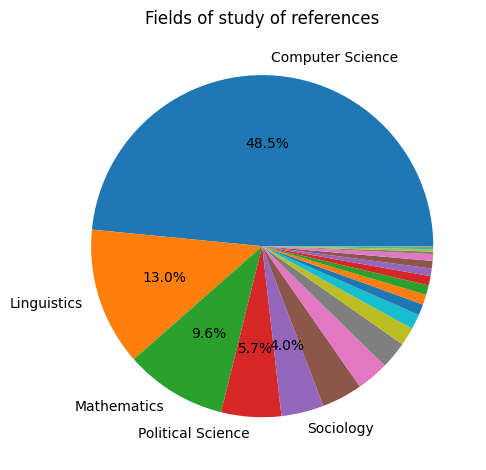

In [24]:
mod_FOS = list(FOS[:5]) + len(FOS[5:]) * ['']
# mod_freqs = list(freqs[:5]) + [sum(freqs[5:])]
mod_freqs = freqs

def autopct_format(pct):
    if pct > 4.0:
        return str("%.1f" % pct) + "%"
    return ''

plt.pie(mod_freqs, labels=mod_FOS, autopct=autopct_format)
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.title('Fields of study of references')
plt.tight_layout()
plt.savefig('network-analysis-plots/fos.png')
plt.show()

In [25]:
intra_FOS = set(['Computer Science', 'Linguistics', 'Mathematics', 'Engineering'])

In [26]:
prop_other_FOS = []
zero = 0
one = 0

for corpusId, refs in data.items():
    num_other_FOS = 0
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            flag = False
            for fos in ref['citedPaper']['s2FieldsOfStudy']:
                if fos['category'] in intra_FOS:
                    flag = True
                    break
            if not flag:
                num_other_FOS += 1
    if len(refs) > 0:
        prop_other_FOS.append(num_other_FOS / len(refs))
        zero += int(num_other_FOS == 0)
        one += int(num_other_FOS == 1)

In [27]:
zero, one

(177, 87)

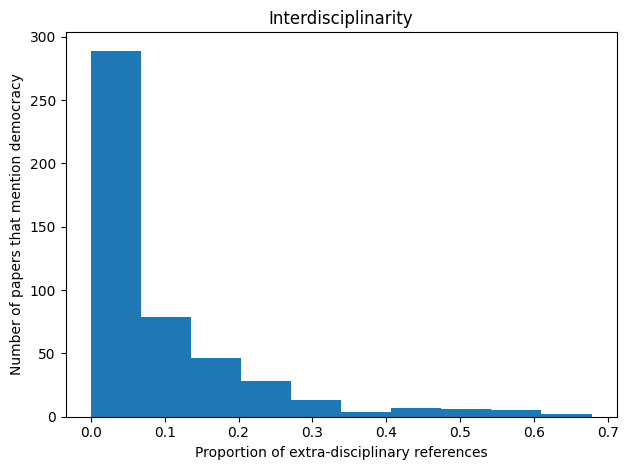

In [29]:
plt.hist(prop_other_FOS)
plt.ylabel('Number of papers that mention democracy')
plt.xlabel('Proportion of extra-disciplinary references')
plt.title('Interdisciplinarity')
plt.tight_layout()
plt.savefig('network-analysis-plots/interdisciplinarity.png')
plt.show()

## Intents

In [30]:
all_intents = []

for corpusId, refs in data.items():
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            flag = False
            for fos in ref['citedPaper']['s2FieldsOfStudy']:
                if fos['category'] in intra_FOS:
                    flag = True
                    break
            if not flag:
                ref_intents = set()
                for context in ref['contextsWithIntent']:
                    ref_intents.update(set(context['intents']))
                all_intents.extend(list(ref_intents))

[82.43243243 15.39039039  2.17717718]


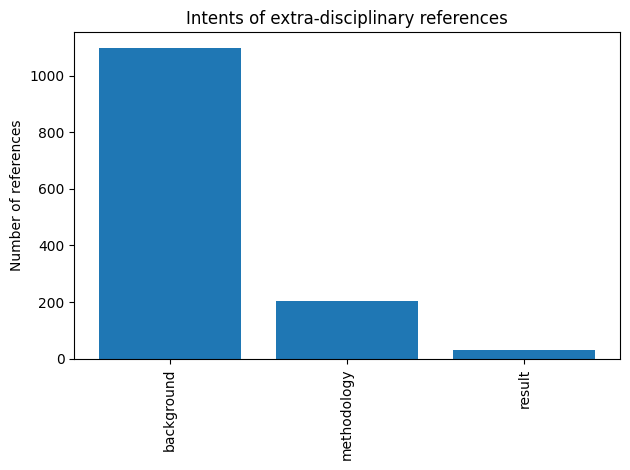

In [34]:
intents_freqs = Counter(all_intents)
intents, freqs = list(zip(*intents_freqs.most_common()))

print(np.array(freqs) / sum(freqs) * 100)

plt.bar(intents, freqs)
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of references')
plt.title('Intents of extra-disciplinary references')
plt.tight_layout()
plt.savefig('network-analysis-plots/intents.png')
plt.show()

## Venues

In [35]:
all_venues = []

for corpusId, refs in data.items():
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            if len(ref['citedPaper']['venue']) > 0:
                all_venues.append(ref['citedPaper']['venue'])

In [50]:
def convert_venues(venue):
    venue_map = {
        'Conference of the European Chapter of the Association for Computational Linguistics' : '*CL',
        'Conference on Empirical Methods in Natural Language Processing' : '*CL',
        'Annual Meeting of the Association for Computational Linguistics' : '*CL',
        'Transactions of the Association for Computational Linguistics' : '*CL',
        'North American Chapter of the Association for Computational Linguistics' : '*CL',
        'Findings' : '*CL',
        'Neural Information Processing Systems' : 'ICLR/ICML/NeurIPS',
        'International Conference on Learning Representations' : 'ICLR/ICML/NeurIPS',
        'International Conference on Machine Learning' : 'ICLR/ICML/NeurIPS',
        'IEEE International Conference on Computer Vision' : 'CVPR/ICCV/ECCV',
        'Computer Vision and Pattern Recognition' : 'CVPR/ICCV/ECCV',
        'European Conference on Computer Vision' : 'CVPR/ICCV/ECCV',
    }
    if venue in venue_map:
        return venue_map[venue]
    return venue

In [51]:
all_venues

['Conference of the European Chapter of the Association for Computational Linguistics',
 'International Conference on Natural Language Generation',
 'Language Resources and Evaluation',
 'Proc. ACM Hum. Comput. Interact.',
 'Findings',
 'Conference of the European Chapter of the Association for Computational Linguistics',
 'Conference on Empirical Methods in Natural Language Processing',
 'Conference on Empirical Methods in Natural Language Processing',
 'Annual Meeting of the Association for Computational Linguistics',
 'Annual Meeting of the Association for Computational Linguistics',
 'International Conference on Learning Representations',
 'International Conference on Language Resources and Evaluation',
 'AAAI Conference on Artificial Intelligence',
 'AAAI Conference on Artificial Intelligence',
 'Neural Information Processing Systems',
 'North American Chapter of the Association for Computational Linguistics',
 'RepL4NLP@ACL',
 'The Web Conference',
 'Proc. ACM Hum. Comput. Intera

/var/folders/8m/njp7bcbj6wbfvt5l__spxy_00000gn/T/ipykernel_6591/3058379361.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(map(f, plt.gca().get_xticklabels()))


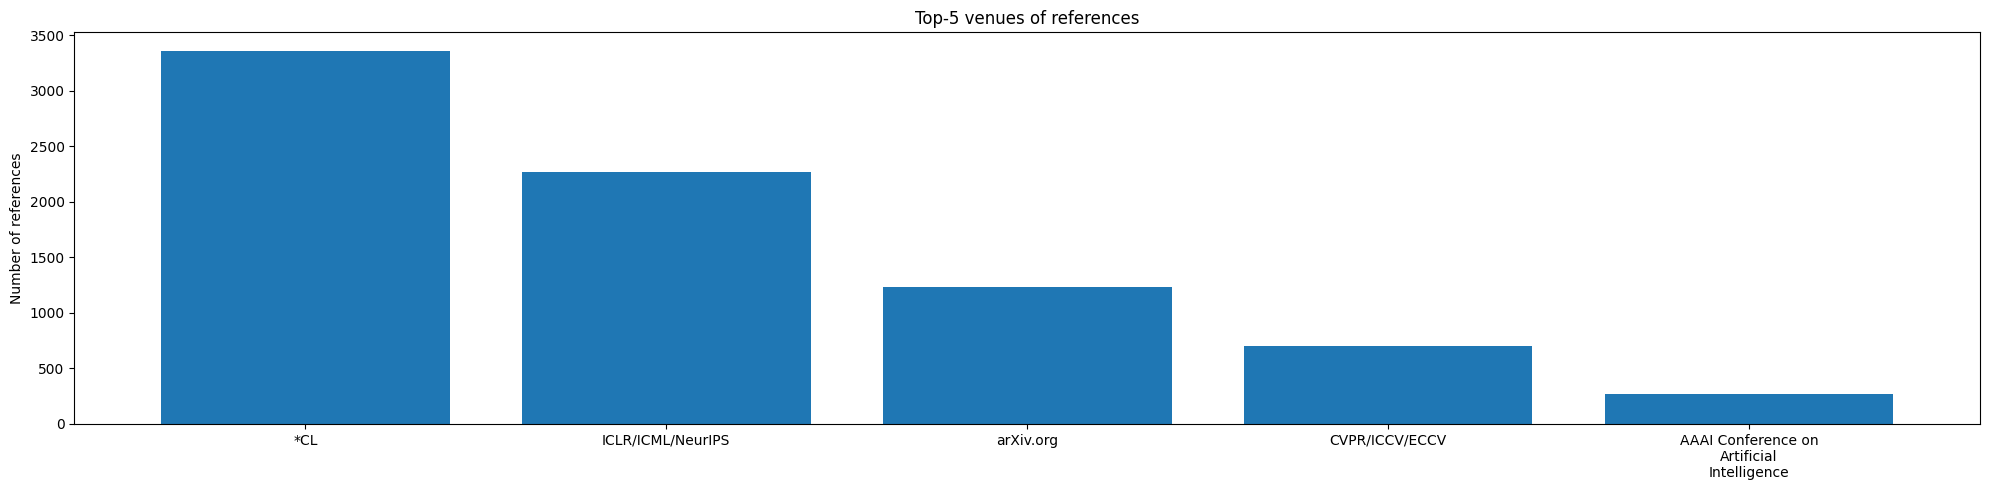

In [55]:
venue_freqs = Counter([convert_venues(v) for v in all_venues])
venues, freqs = list(zip(*venue_freqs.most_common(5)))

plt.figure(figsize=(20, 5))
plt.bar(venues, freqs)
# for tick in plt.gca().get_xticklabels():
#     tick.set_rotation(90)
f = lambda x: textwrap.fill(x.get_text(), 20)
plt.gca().set_xticklabels(map(f, plt.gca().get_xticklabels()))
plt.ylabel('Number of references')
plt.title('Top-5 venues of references')
plt.tight_layout()
plt.savefig('network-analysis-plots/venues.png')
plt.show()

In [16]:
all_extra_venues = []

for corpusId, refs in data.items():
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            flag = False
            for fos in ref['citedPaper']['s2FieldsOfStudy']:
                if fos['category'] in intra_FOS:
                    flag = True
                    break
            if not flag:
                if len(ref['citedPaper']['venue']) > 0:
                    all_extra_venues.append(ref['citedPaper']['venue'])

/var/folders/8m/njp7bcbj6wbfvt5l__spxy_00000gn/T/ipykernel_45056/125126037.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(map(f, plt.gca().get_xticklabels()))


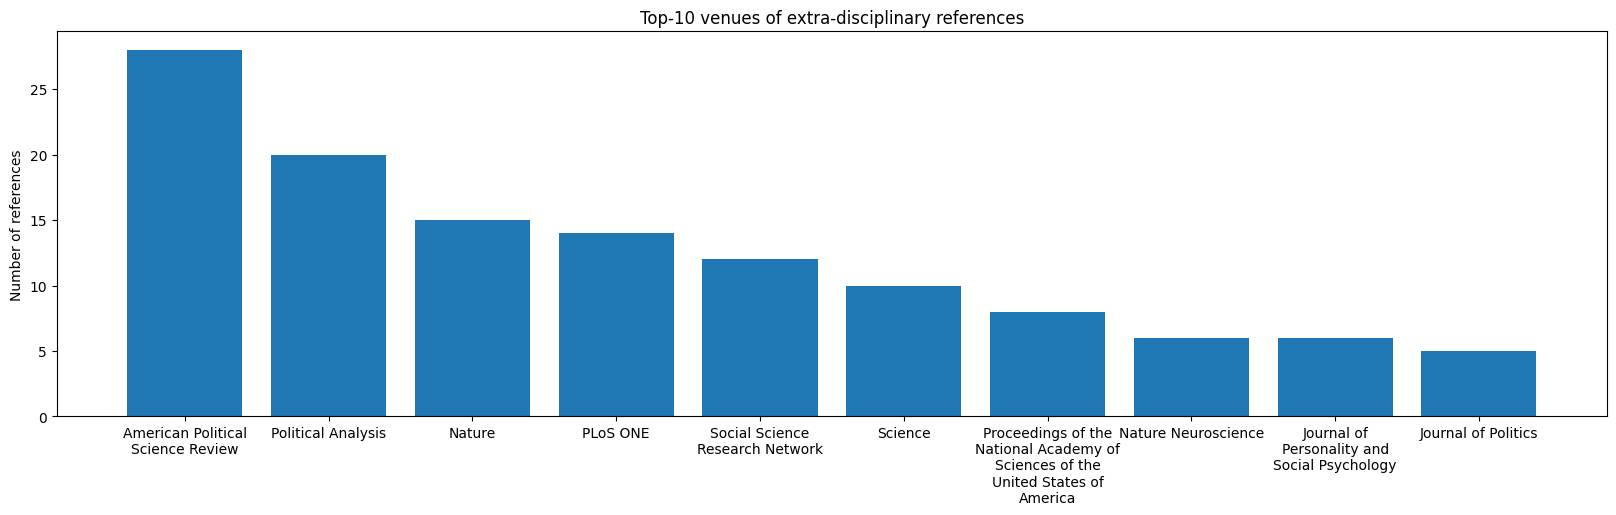

In [17]:
venue_freqs = Counter(all_extra_venues)
venues, freqs = list(zip(*venue_freqs.most_common(10)))

plt.figure(figsize=(20, 5))
plt.bar(venues, freqs)
# for tick in plt.gca().get_xticklabels():
#     tick.set_rotation(90)
f = lambda x: textwrap.fill(x.get_text(), 20)
plt.gca().set_xticklabels(map(f, plt.gca().get_xticklabels()))
plt.ylabel('Number of references')
plt.title('Top-10 venues of extra-disciplinary references')
plt.savefig('network-analysis-plots/extra-venues.png')
plt.show()

## Most Cited

In [18]:
all_titles = []

for corpusId, refs in data.items():
    for ref in refs:
        if 'citedPaper' in ref and 's2FieldsOfStudy' in ref['citedPaper'] and ref['citedPaper']['s2FieldsOfStudy'] is not None:
            flag = False
            for fos in ref['citedPaper']['s2FieldsOfStudy']:
                if fos['category'] in intra_FOS:
                    flag = True
                    break
            if not flag:
                if len(ref['citedPaper']['title']) > 0:
                    all_titles.append(ref['citedPaper']['title'])

/var/folders/8m/njp7bcbj6wbfvt5l__spxy_00000gn/T/ipykernel_45056/791930749.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(map(f, plt.gca().get_xticklabels()))


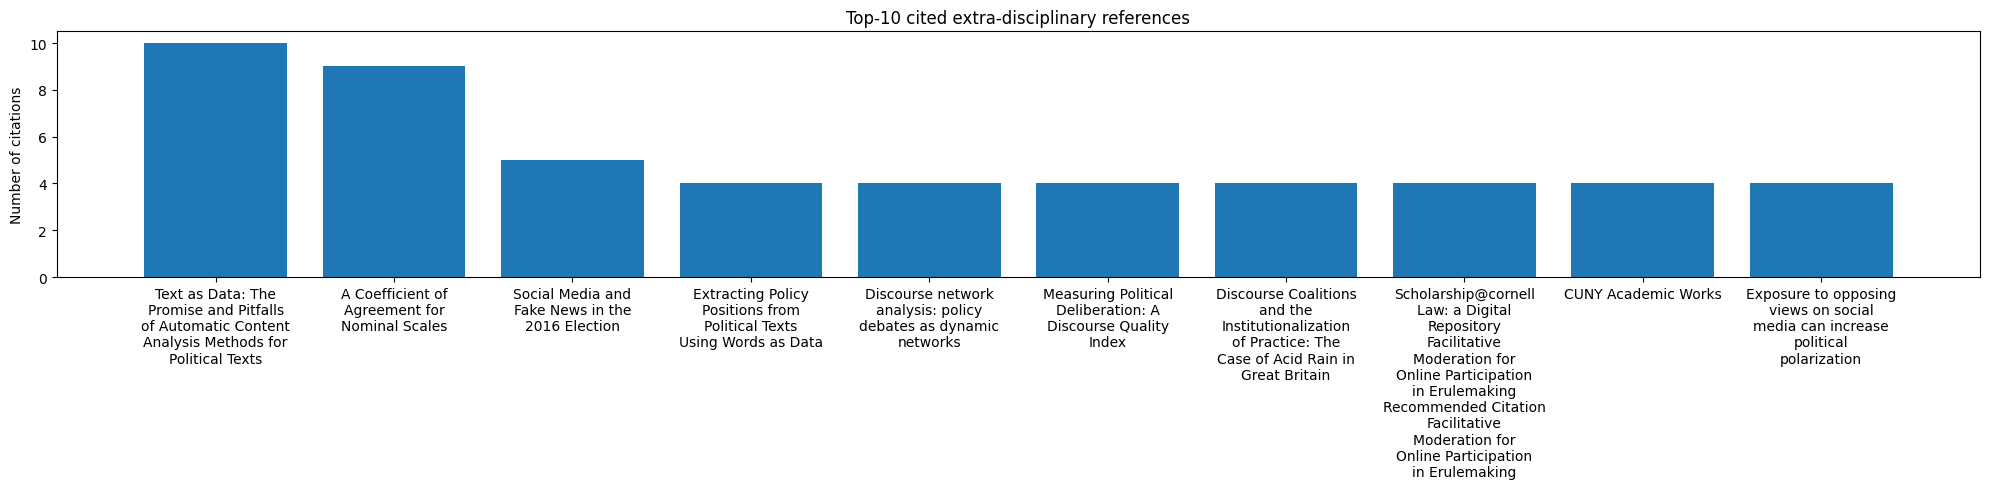

In [19]:
title_freqs = Counter(all_titles)
titles, freqs = list(zip(*title_freqs.most_common(10)))

plt.figure(figsize=(20, 5))
plt.bar(titles, freqs)
# for tick in plt.gca().get_xticklabels():
#     tick.set_rotation(90)
f = lambda x: textwrap.fill(x.get_text(), 20)
plt.gca().set_xticklabels(map(f, plt.gca().get_xticklabels()))
plt.ylabel('Number of citations')
plt.title('Top-10 cited extra-disciplinary references')
plt.tight_layout()
plt.savefig('network-analysis-plots/extra-refs.png')
plt.show()